In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np

from skimage.measure import regionprops



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [51]:
_ = project_data.segmentation_metadata

In [3]:
all_frames = project_data.raw_frames
all_matches = project_data.raw_matches

# Use within tracklet and between tracklet examples to train a classifier

## First, just look at data loading 

Follows this paper:
https://arxiv.org/pdf/2006.02609.pdf

In [3]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17/2-training_data/raw/clust_df_dat.pickle"
df = pd.read_pickle(fname)

In [4]:
df.head()

,clust_ind,all_ind_local,all_xyz,all_prob,slice_ind
0,0,"[0, 5, 1, 1, 1, 1, 4, 4, 3, 0, 4, 4, 2, 4, 3, ...","[[4.8771146066011655, 297.7740983145629, 424.0...","[[0.3664077302417685], [0.15163196729664105], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[1, 4, 4, 2, 5, 7, 6, 7, 7, 7, 7, 1, 3, 9, 10,...","[[4.5420842803383135, 313.3114124967398, 433.1...","[[0.2292424971146307], [0.25094726101312165], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,2,"[2, 2, 0, 5, 6, 8, 8, 12, 9, 9, 6, 2, 7, 1, 0,...","[[5.850456465458509, 279.90286483172093, 417.9...","[[0.32134276791509425], [0.25540217827506717],...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,3,"[3, 9, 6, 6, 8, 10, 9, 154, 146, 6, 5, 0, 4, 7...","[[6.150039738760841, 300.02505269705244, 349.5...","[[0.2654288643409178], [0.430321175706038], [0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,4,"[4, 8, 8, 9, 9, 11, 13, 13, 10, 13, 10, 9, 14,...","[[6.238351989685284, 308.2635234132333, 399.32...","[[0.3794733326848895], [0.3498234953136751], [...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [317]:
def get_bbox_data(i_tracklet, df, project_data, t_local=None, target_sz=np.array([8, 64, 64])):
    """if t_local is None, chooses a random time"""
    # Note that .at properly selects the row by index even if some rows are dropped
    track_seg_ind = df.at[i_tracklet, 'all_ind_local']
    track_time_ind = df.at[i_tracklet, 'slice_ind']
    
    if t_local is None:
        t_max = len(track_seg_ind)
        t_local = np.random.randint(0, t_max)

    t_global = track_time_ind[t_local]
    i_local = track_seg_ind[t_local]

    seg_local = project_data.segmentation_metadata.seg_array_to_mask_index(t_global, i_local)
    
    # Get a bbox for a neuron in 3d
    this_seg = project_data.raw_segmentation[t_global, ...]
    props = regionprops(this_seg)
    
    p = [p for p in props if p.label==seg_local][0]
    
    bbox = p.bbox
    
    # Expand to get the neighborhood
    sz = project_data.red_data.shape
    
    z0 = np.clip(bbox[0] - 3, a_min=0, a_max=sz[1])
    z1 = np.clip(bbox[3] + 3, a_min=0, a_max=sz[1])
    if z1 - z0 > target_sz[0]:
        z1 = z0 + target_sz[0]
    x0 = np.clip(bbox[1] - 30, a_min=0, a_max=sz[2])
    x1 = np.clip(bbox[4] + 30, a_min=0, a_max=sz[2])
    if x1 - x0 > target_sz[1]:
        x1 = x0 + target_sz[1]
    y0 = np.clip(bbox[2] - 30, a_min=0, a_max=sz[3])
    y1 = np.clip(bbox[5] + 30, a_min=0, a_max=sz[3])
    if y1 - y0 > target_sz[2]:
        y1 = y0 + target_sz[2]
    
    dat = project_data.red_data[t_global, z0:z1, x0:x1, y0:y1]
    
    # Pad, if needed, to the beginning
    diff_sz = np.clip(target_sz - np.array(dat.shape), a_min=0, a_max=np.max(target_sz))
    pad_sz = list(zip(diff_sz, np.zeros(len(diff_sz), dtype=int)))
    dat = np.pad(dat, pad_sz)
    
    return dat, bbox

# MAX_TRACKLET = df.shape[0]
def get_siamese_training_triplet(df, project_data):
    
    rng = np.random.default_rng()
    rand_order = rng.permutation(list(df_long_tracklets.index))
    
    # Two examples from same, one different
    i_tracklet0 = rand_order[0]
    dat_anchor, _ = get_bbox_data(i_tracklet0, df, project_data, t_local=None)
    dat_pos, _ = get_bbox_data(i_tracklet0, df, project_data, t_local=None)
    
    i_tracklet1 = rand_order[1]
    dat_neg, _ = get_bbox_data(i_tracklet1, df, project_data, t_local=None)
    
    return dat_anchor, dat_pos, i_tracklet0, dat_neg, i_tracklet1

In [49]:
dat, bbox = get_bbox_data(i_tracklet=0, t_local=0, df=df, project_data=project_data)

# Load a positive/negative example triplet

In [ ]:
dat_p0, bbox0 = get_bbox_data(i_tracklet=0, t_local=0, df=df, project_data=project_data)
dat_p1, bbox1 = get_bbox_data(i_tracklet=0, t_local=1, df=df, project_data=project_data)
dat_m0, bbox2 = get_bbox_data(i_tracklet=1, t_local=0, df=df, project_data=project_data)

In [155]:
# v = napari.view_image(dat_p0, ndisplay=3, colormap='green')
# v.add_image(dat_p1, colormap='red')
# v.add_image(dat_m0, colormap='blue')

# Load a positive/negative example triplet

In [67]:
dat_p0, dat_p1, dat_m0 = get_siamese_training_triplet(df, project_data)

In [68]:
dat_p0.shape, dat_p1.shape, dat_m0.shape

((8, 64, 64), (8, 64, 64), (8, 64, 64))

In [175]:
v = napari.view_image(dat_p0, ndisplay=3, colormap='green')
v.add_image(dat_p1, colormap='red')
v.add_image(dat_m0, colormap='blue')

<Image layer 'dat_m0' at 0x7f519597b490>

# Siamese network

From here: https://github.com/fangpin/siamese-pytorch/blob/master/model.py

and loss from here: https://www.kaggle.com/hirotaka0122/triplet-loss-with-pytorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

In [286]:
def calc_euclidean(x1, x2):
    return (x1 - x2).pow(2).sum(1)


def predict_same_or_not(d0, d1):
    distance = calc_euclidean(d0, d1)
    return torch.relu(distance)


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

    
class Siamese(nn.Module):

    def __init__(self, embedding_dim=4096):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 64, 4, padding=3),  # 64@8*64*64
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 64@4*32*32
            nn.Conv3d(64, 128, 4),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 128@2*16*16
            nn.Conv3d(128, 128, (1, 2, 2)),
            nn.ReLU(),    # 128@1*14*14
        )
        self.liner = nn.Sequential(nn.Linear(128*1*14*14, embedding_dim), nn.Sigmoid())
        self.out = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    # def forward(self, x1, x2):
    #     out1 = self.forward_one(x1)
    #     out2 = self.forward_one(x2)
    #     dis = torch.abs(out1 - out2)
    #     out = self.out(dis)
    #     #  return self.sigmoid(out)
    #     return out
    
    
def get_one_triplet(df, project_data):
    d0, d1, label1, d2, label2 = get_siamese_training_triplet(df, project_data)
    d0, d1, d2 = torch.from_numpy(d0.astype(np.uint8)), torch.from_numpy(d1.astype(np.uint8)), torch.from_numpy(d2.astype(np.uint8))
    d0 = torch.unsqueeze(d0, 0)
    d0 = torch.unsqueeze(d0, 0).float() / 255.0
    d1 = torch.unsqueeze(d1, 0)
    d1 = torch.unsqueeze(d1, 0).float() / 255.0
    d2 = torch.unsqueeze(d2, 0)
    d2 = torch.unsqueeze(d2, 0).float() / 255.0
    return d0, d1, label1, d2, label2


def build_train_loader(df, project_data, max_iters=100):
    for i in range(max_iters):
        yield get_one_triplet(df, project_data)


# def build_epoch_loader(max_epochs, *args):
#     for i in range(max_epochs):
#         yield build_train_loader(*args)

        
def build_train_loader_batch(df, project_data, max_iters=100, batch_size=4):
    for i in range(max_iters):
        all_d0, all_d1, all_d2 = [], [], []
        for i2 in range(batch_size):
            d0, d1, label1, d2, label2 = get_one_triplet(df, project_data)
            all_d0.append(d0)
            all_d1.append(d1)
            all_d2.append(d2)
        yield (torch.cat(all_d0, 0), torch.cat(all_d1, 0), None, torch.cat(all_d2, 0), None)
        

In [287]:
# Only allow a subset of tracklets to be used
len_thresh = 300
to_keep = df['all_ind_local'].apply(len) > len_thresh
df_long_tracklets = df.loc[to_keep].copy()
# df_long_tracklets.head()

In [423]:
from wbfm.utils.nn_utils.siamese import Siamese
model = Siamese(embedding_dim=16)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.TripletMarginLoss(margin=1.0)
# criterion = torch.jit.script(TripletLoss())
# criterion = torch.jit.script(nn.CrossEntropyLoss())

training_opt = {'df': df_long_tracklets, 'project_data': project_data, 'max_iters': 10, 'batch_size': 32}
epochs = 100
device = 'cpu'
clip_value = 5

In [361]:
from wbfm.utils.nn_utils.data_loading import save_training_data
# save_training_data(df_long_tracklets, project_data, num_triplets=1000)

In [399]:
from wbfm.utils.nn_utils.data_loading import NeuronTripletDataset
from torch.utils.data import DataLoader
training_folder = os.path.join(project_data.project_dir, 'nn_training')
training_dataset = NeuronTripletDataset(training_folder)
train_loader = DataLoader(training_dataset, batch_size=4)

In [400]:
len(training_dataset)

1000

In [401]:
# Don't worry about all of the data for now
from torch.utils.data import random_split
small_dataset, large_dataset = random_split(training_dataset, [100, 900], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(small_dataset, batch_size=32)
len(small_dataset)

100

In [402]:
import wandb
import os

In [424]:
model.train()


all_losses = []
with wandb.init(project="my-test-project", entity="charlesfieseler"):
    wandb.watch(model, log='all', log_freq=1)
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        # train_loader = build_train_loader(**training_opt)
        # train_loader = build_train_loader_batch(**training_opt)

        for step, (anchor_img, positive_img, pos_label, negative_img, neg_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)
            loss = criterion(anchor_out, positive_out, negative_out)

            # pos_examples_are_same = model(anchor_img, positive_img)
            # neg_examples_are_diff = model(anchor_img, negative_img)

            loss.backward()

            # From: https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            this_loss = loss.cpu().detach().numpy()
            running_loss.append(this_loss)
            if np.isnan(this_loss):
                print("Loss is nan, stopping")
                break
        all_losses.extend(running_loss)
        if epoch % 10 == 0:
            fname = os.path.join(training_folder, f'siamese_epoch{epoch}')
            torch.save(model.state_dict(), fname)

        wandb.log({'Loss': this_loss})
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1/100 - Loss: 0.6205


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2/100 - Loss: 0.2676


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3/100 - Loss: 0.1922


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4/100 - Loss: 0.1253


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5/100 - Loss: 0.1074


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 6/100 - Loss: 0.0556


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 7/100 - Loss: 0.0432


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 8/100 - Loss: 0.0373


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 9/100 - Loss: 0.0258


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10/100 - Loss: 0.0182


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11/100 - Loss: 0.0138


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12/100 - Loss: 0.0134


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13/100 - Loss: 0.0150


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14/100 - Loss: 0.0122


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15/100 - Loss: 0.0124


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16/100 - Loss: 0.0220


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17/100 - Loss: 0.0348


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18/100 - Loss: 0.0189


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19/100 - Loss: 0.0140


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20/100 - Loss: 0.0167


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21/100 - Loss: 0.0154


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22/100 - Loss: 0.0810


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23/100 - Loss: 0.0432


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24/100 - Loss: 0.0400


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25/100 - Loss: 0.0446


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26/100 - Loss: 0.0372


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27/100 - Loss: 0.0383


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28/100 - Loss: 0.0281


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29/100 - Loss: 0.0215


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30/100 - Loss: 0.0294


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31/100 - Loss: 0.0232


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32/100 - Loss: 0.0361


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33/100 - Loss: 0.0352


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34/100 - Loss: 0.0234


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35/100 - Loss: 0.0193


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36/100 - Loss: 0.0256


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37/100 - Loss: 0.0136


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38/100 - Loss: 0.0157


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39/100 - Loss: 0.0105


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40/100 - Loss: 0.0084


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41/100 - Loss: 0.0117


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42/100 - Loss: 0.0093


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43/100 - Loss: 0.0123


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44/100 - Loss: 0.0088


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45/100 - Loss: 0.0083


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46/100 - Loss: 0.0060


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47/100 - Loss: 0.0045


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48/100 - Loss: 0.0047


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49/100 - Loss: 0.0043


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50/100 - Loss: 0.0043


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 51/100 - Loss: 0.0041


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 52/100 - Loss: 0.0041


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 53/100 - Loss: 0.0041


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 54/100 - Loss: 0.0040


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 55/100 - Loss: 0.0040


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 56/100 - Loss: 0.0040


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 57/100 - Loss: 0.0039


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 58/100 - Loss: 0.0039


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 59/100 - Loss: 0.0037


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 60/100 - Loss: 0.0036


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 61/100 - Loss: 0.0035


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 62/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 63/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 64/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 65/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 66/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 67/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 68/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 69/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 70/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 71/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 72/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 73/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 74/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 75/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 76/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 77/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 78/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 79/100 - Loss: 0.0042


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 80/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 81/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 82/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 83/100 - Loss: 0.0034


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 84/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 85/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 86/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 87/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 88/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 89/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 90/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 91/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 92/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 93/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 94/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 95/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 96/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 97/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 98/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 99/100 - Loss: 0.0033


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 100/100 - Loss: 0.0033


Loss,█▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,0.0


In [436]:
model.eval()

d0, d1, label1, d2, label2 = get_one_triplet(df, project_data)

same = predict_same_or_not(model(d0), model(d1))
diff = predict_same_or_not(model(d0), model(d2))
print(same, diff)

tensor([2.8645e-11], grad_fn=<ReluBackward0>) tensor([1.9979], grad_fn=<ReluBackward0>)


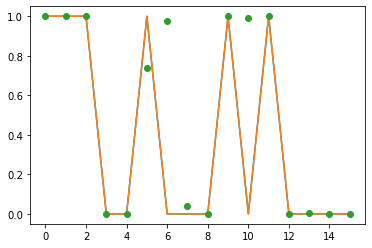

In [437]:
plt.plot(model(d0).detach().numpy().T)
plt.plot(model(d1).detach().numpy().T)
plt.plot(model(d2).detach().numpy().T, 'o')
plt.show()

In [518]:
v = napari.view_image(d0.detach().numpy(), ndisplay=3, colormap='green')
v.add_image(d1.detach().numpy(), colormap='red')
v.add_image(d2.detach().numpy(), colormap='blue')

<Image layer 'Image [2]' at 0x7fb71758d790>

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/asyncio/base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/pyth

In [504]:
# PCA plot
test_loader = DataLoader(large_dataset, batch_size=1)
all_data = []
label_of_each_row = []
all_val_loss = []

for step, (anchor_img, positive_img, pos_label, negative_img, neg_label) in enumerate(tqdm(test_loader, desc="Training", leave=False)):
    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)
    all_data.append(anchor_out.detach().numpy().T)
    all_data.append(positive_out.detach().numpy().T)
    all_data.append(negative_out.detach().numpy().T)
    
    label_of_each_row.append(pos_label)
    label_of_each_row.append(pos_label)
    label_of_each_row.append(neg_label)
    
    loss = criterion(anchor_out, positive_out, negative_out)
    all_val_loss.append(loss.cpu().detach().numpy())
    
    if step > 200:
        break

array_data = np.array(all_data)

Training:   0%|          | 0/900 [00:00<?, ?it/s]

(array([134.,  13.,  18.,  19.,   7.,   6.,   1.,   1.,   2.,   1.]),
 array([0.        , 0.26456338, 0.52912676, 0.7936901 , 1.0582535 ,
        1.3228168 , 1.5873802 , 1.8519436 , 2.116507  , 2.3810704 ,
        2.6456337 ], dtype=float32),
 <a list of 10 Patch objects>)

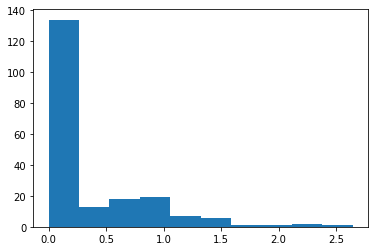

In [506]:
plt.hist(all_val_loss)

In [510]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_proj = pca.fit_transform(np.squeeze(array_data))

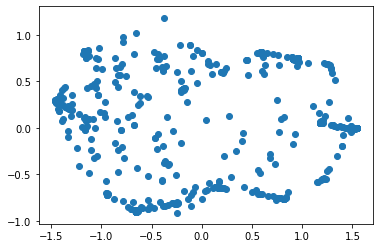

In [511]:
plt.scatter(pca_proj[:, 0], pca_proj[:, 1])

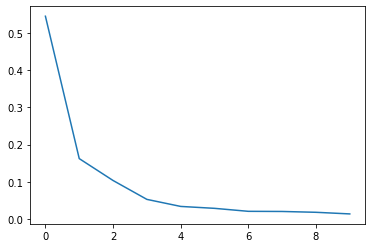

In [512]:
plt.plot(pca.explained_variance_ratio_);

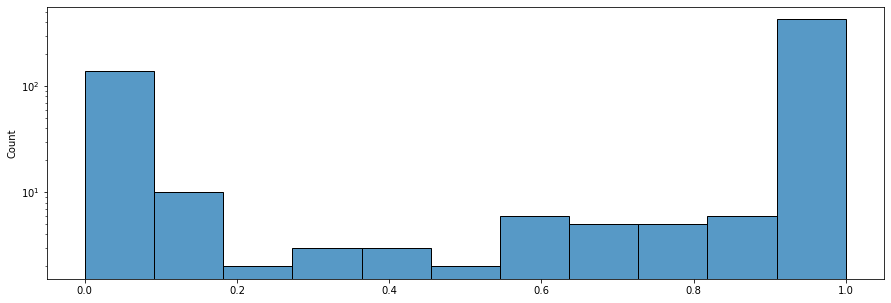

In [513]:
import seaborn as sns
plt.figure(figsize=(15,5))
dat = np.squeeze(array_data).T
sns.histplot(dat[1, :], );
plt.yscale("log")

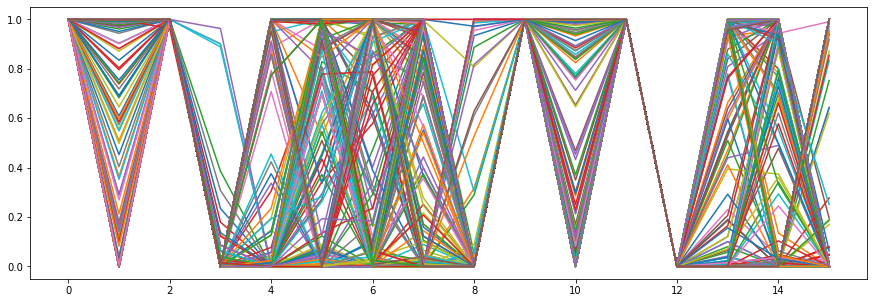

In [514]:

plt.figure(figsize=(15,5))
dat = np.squeeze(array_data).T
plt.plot(dat);

# Use weights and biases

In [ ]:
from wbfm.utils.nn_utils.data_loading import save_training_data

save_training_data(df, project_data, num_triplets=10)

In [337]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 8
}
wandb.log({"loss": loss})

# Optional
wandb.watch(model)

[]

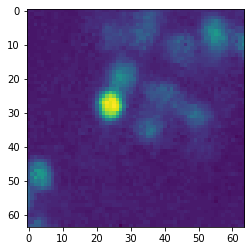

In [319]:
plt.imshow(d0[0, 0, 5,...])

In [176]:
target = torch.empty((2, 1), dtype=torch.long)
target[0] = 0
target[1] = 1
target.shape, target

(torch.Size([2, 1]),
 tensor([[0],
         [1]]))

In [173]:
# # Example of target with class probabilities
# input = torch.randn(3, requires_grad=True)
# target = torch.randn(3).softmax(dim=0)
# output = loss(input, target)
# output.backward()

In [191]:
from torch.autograd import Variable
pred = model(d0, d1)
target = Variable(torch.from_numpy(np.array([1], dtype=np.float32)))
loss_fn = torch.nn.BCEWithLogitsLoss()
loss(pred, target)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


RuntimeError: expected scalar type Long but found Float

In [387]:

d1 = nn.Conv3d(1, 64, 4, padding=3)(d0)
d2 = nn.ReLU(inplace=True)(d1)
d3 = nn.MaxPool3d(2)(d2)
d4 = nn.Conv3d(64, 128, 4)(d3)
d5 = nn.ReLU(inplace=True)(d4)
d6 = nn.MaxPool3d(2)(d5)
d7 = nn.Conv3d(128, 128, (1, 2, 2))(d6)
d8 = nn.ReLU()(d7)

In [388]:
d0.shape, d1.shape, d2.shape, d8.shape

(torch.Size([1, 1, 8, 64, 64]),
 torch.Size([1, 64, 11, 67, 67]),
 torch.Size([1, 64, 11, 67, 67]),
 torch.Size([1, 128, 1, 14, 14]))

In [84]:
# With square kernels and equal stride
m = nn.Conv3d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.Conv3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(4, 2, 0))
input = torch.randn(20, 16, 10, 50, 100)
output = m(input)

In [100]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 4, 2])

In [101]:
torch.randn(3, 5, requires_grad=True).shape

torch.Size([3, 5])

In [394]:
nn.BatchNorm3d(128)(d4).shape

torch.Size([1, 128, 2, 30, 30])